# Lab 01 : Deep Q-Learning (DQN) - demo


In [ ]:
# For Google Colaboratory
import sys, os
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/gdrive')
    file_name = 'DQN_demo.ipynb'
    import subprocess
    path_to_file = subprocess.check_output('find . -type f -name ' + str(file_name), shell=True).decode("utf-8")
    print(path_to_file)
    path_to_file = path_to_file.replace(file_name,"").replace('\n',"")
    os.chdir(path_to_file)
    !pwd

In [1]:

import torch
import torch.nn as nn
torch.manual_seed(torch.randint(10000,())) # random seed for pythorch random generator

import time
import numpy as np

import os
import pickle

import gym

import matplotlib
import matplotlib.pyplot as plt
from IPython import display

from collections import namedtuple
import random
from itertools import count


# Dataset

In [2]:

#Env parameters
env_seed = 1
render = True # display on
render = False # display off

#Initialize the environment with the same seed/initialization value
env = gym.make('CartPole-v0')
env.seed(env_seed)

#Reset the environment
state = env.reset() 
print('init state:',state)

#Rollout one episode until it finishes 
for t in count():  
    action = torch.LongTensor(1).random_(0,2).item() # randomly generated action=a in {0,1}
    state, reward, done, _ = env.step(action) # receive next state=s' and reward=r
    print('t=',t, 'action=',action, 'state=',np.array_str(state, precision=5), 'reward=',reward, 'done=',done )
    if render:
        env.render() # see the state
    if done:
        break


init state: [ 0.03073904  0.00145001 -0.03088818 -0.03131252]
t= 0 action= 1 state= [ 0.03077  0.197   -0.03151 -0.33358] reward= 1.0 done= False
t= 1 action= 1 state= [ 0.03471  0.39256 -0.03819 -0.63603] reward= 1.0 done= False
t= 2 action= 1 state= [ 0.04256  0.58819 -0.05091 -0.94049] reward= 1.0 done= False
t= 3 action= 0 state= [ 0.05432  0.39379 -0.06972 -0.66423] reward= 1.0 done= False
t= 4 action= 0 state= [ 0.0622   0.1997  -0.083   -0.39429] reward= 1.0 done= False
t= 5 action= 0 state= [ 0.06619  0.00585 -0.09089 -0.12888] reward= 1.0 done= False
t= 6 action= 0 state= [ 0.06631 -0.18786 -0.09346  0.1338 ] reward= 1.0 done= False
t= 7 action= 0 state= [ 0.06255 -0.38153 -0.09079  0.39559] reward= 1.0 done= False
t= 8 action= 1 state= [ 0.05492 -0.18524 -0.08288  0.07572] reward= 1.0 done= False
t= 9 action= 1 state= [ 0.05122  0.01096 -0.08136 -0.24191] reward= 1.0 done= False
t= 10 action= 0 state= [ 0.05144 -0.18291 -0.0862   0.02404] reward= 1.0 done= False
t= 11 action=

# Replay Memory 

In [3]:
Transition = namedtuple( 'Transition', ('state', 'action', 'next_state', 'reward', 'done') )

# class of replay memory/experience 
class ReplayMemory(object):
    
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def write(self, *args): # store transitions (s, a, s', r)
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def read(self, batch_size): # select a random batch of transitions 
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory) 
    

In [4]:

# Initialize the replay memory
memory = ReplayMemory(10000) 

#Write/store the transition in memory       
state = torch.FloatTensor(env.reset())
action = torch.tensor(0).long()
next_state = torch.FloatTensor(env.reset())
reward = torch.tensor(1).float()
done = torch.tensor(0).long()
memory.write(state,action,next_state,reward,done)
print('memory size',memory.__len__())

#Read a batch of transitions (s, a, s', r) from replay memory 
batch_size = 1
batch_transitions = memory.read(batch_size)  
print('batch_transitions',batch_transitions)


memory size 1
batch_transitions [Transition(state=tensor([ 0.0273, -0.0448, -0.0430,  0.0015]), action=tensor(0), next_state=tensor([ 0.0189, -0.0040,  0.0402,  0.0275]), reward=tensor(1.), done=tensor(0))]


# Define the policy network

In [5]:

# class of policy network
class Q_NN(nn.Module): 
    
    def __init__(self, net_parameters):
        super(Q_NN, self).__init__()
        input_dim = net_parameters['input_dim']
        hidden_dim = net_parameters['hidden_dim']
        output_dim = net_parameters['output_dim']
        self.fc1 = nn.Linear(input_dim, hidden_dim, bias=True)
        self.fc2 = nn.Linear(hidden_dim, output_dim, bias=True)
        
    def forward(self, x): 
        x = torch.relu(self.fc1(x))
        Q_scores = self.fc2(x) # scores over actions 
        return Q_scores
    
    def select_action(self, state, rand_act_pr): # select action w/ Q network
        Q_scores = self.forward(state) # Q(a|s) scores of action a in state s
        coin = random.random()
        if coin < rand_act_pr: # (state,action) exploration process parametrized by rand_act_pr
            action = torch.randint(0,2,()).item()
        else:
            action = Q_scores.argmax().item()
        return action
    
    def loss(self, memory, baseline_Q_net, opt_parameters):
        batch_size = opt_parameters['batch_size']
        gamma = opt_parameters['gamma']
        if memory.__len__()>=batch_size: # read a batch of transitions (s,a,s',r) in replay memory 
            batch_transitions = Transition(*zip(*memory.read(batch_size)))
        else:
            batch_transitions = Transition(*zip(*memory.read(memory.__len__()))) 
        batch_states = torch.stack([x for x in batch_transitions.state]).float() # state=s, size=B x 4
        batch_next_states = torch.stack([x for x in batch_transitions.next_state]).float() # next_state=s', size=B x 4
        batch_rewards = torch.stack([x for x in batch_transitions.reward]).float() # reward=r, size=B 
        batch_actions = torch.stack([x for x in batch_transitions.action]).long() # action=a, size=B
        batch_dones = torch.stack([x for x in batch_transitions.done]).float() # done, size=B
        Q = self.forward(batch_states).gather(dim=1,index=batch_actions.unsqueeze(1)) # Q_W(a|s), size=B x 1
        max_baseline_Q_net = baseline_Q_net.forward(batch_next_states).max(dim=1)[0].detach() * batch_dones 
        Q_target = batch_rewards.unsqueeze(1) + \
            gamma * max_baseline_Q_net.unsqueeze(1) # Q_target = r + gamma . max_a' Q_W^BL(a'|s'), size=B x 1 
        loss = nn.MSELoss()(Q,Q_target) # MSE_Loss(error = Q_target - Q_W)
        return loss
    
    
# class of rollout episodes
class Rollout_Episodes():
    
    def __init__(self):
        super(Rollout_Episodes, self).__init__()
        
    def rollout_batch_episodes(self, env, memory, opt_parameters, Q_Net, write_memory=True):
        nb_episodes_per_batch = opt_parameters['nb_episodes_per_batch']
        env_seeds = opt_parameters['env_seed']
        rand_act_pr = opt_parameters['rand_act_pr']
        batch_episode_lengths = [] 
        for episode in range(nb_episodes_per_batch):
            env.seed(env_seeds[episode].item()) # start with random seed
            state = env.reset() # initial state
            for t in range(1000): # rollout one episode until it finishes
                state_pytorch = torch.from_numpy(state).float().unsqueeze(0) # state=s
                action = Q_Net.select_action(state_pytorch, rand_act_pr) # select action=a from state=s
                next_state, reward, done, _ = env.step(action) # receive next_state=s' and reward=r
                done_mask = 0.0 if done else 1.0
                if write_memory:
                    memory.write(torch.tensor(state),torch.tensor(action),torch.tensor(next_state),
                                 torch.tensor(reward),torch.tensor(done_mask)) 
                state = next_state
                if done:
                    batch_episode_lengths.append(t)
                    break
        return batch_episode_lengths
    

In [6]:

# network parameters
net_parameters = {}
net_parameters['input_dim'] = 4
net_parameters['hidden_dim'] = 128
net_parameters['output_dim'] = 2

# instantiate networks
Qnet = Q_NN(net_parameters)
print(Qnet)
baseline_Qnet = Q_NN(net_parameters).eval() 
baseline_Qnet.load_state_dict(Qnet.state_dict()) 
print(baseline_Qnet)

# instantiate rollout
rollout_Qnet = Rollout_Episodes()
memory = ReplayMemory(10000) 
print('memory size',memory.__len__())

# optimization parameters
opt_parameters = {}
opt_parameters['nb_episodes_per_batch'] = 3
opt_parameters['env_seed'] = torch.LongTensor(opt_parameters['nb_episodes_per_batch']).random_(1,10000)
opt_parameters['rand_act_pr'] = 0.01

env = gym.make('CartPole-v0')

batch_episode_lengths = rollout_Qnet.rollout_batch_episodes(env, memory, opt_parameters, Qnet)
print('batch_episode_lengths:',batch_episode_lengths)
print('memory size',memory.__len__())


Q_NN(
  (fc1): Linear(in_features=4, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)
Q_NN(
  (fc1): Linear(in_features=4, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)
memory size 0
batch_episode_lengths: [8, 7, 9]
memory size 27


# Test forward pass

In [7]:
    
# instantiate memory
memory = ReplayMemory(10000) 

# optimization parameters
opt_parameters = {}
opt_parameters['lr'] = 0.001 
opt_parameters['nb_episodes_per_batch'] = 3
opt_parameters['nb_batches_per_epoch'] = 10
opt_parameters['env_seed'] = torch.LongTensor(opt_parameters['nb_episodes_per_batch']).random_(1,10000)
opt_parameters['batch_size'] = 10
opt_parameters['gamma'] = 0.999
opt_parameters['rand_act_pr'] = 0.01

batch_episode_lengths = Rollout_Episodes().rollout_batch_episodes(env, memory, opt_parameters, Qnet)
print('batch_episode_lengths:',batch_episode_lengths)
print('memory size',memory.__len__())


batch_episode_lengths: [8, 7, 8]
memory size 26


# Test backward pass

In [8]:

# Loss
loss = Qnet.loss(memory, baseline_Qnet, opt_parameters)
print('loss:',loss)

# Backward pass
lr = opt_parameters['lr']
optimizer = torch.optim.Adam(Qnet.parameters(), lr=lr)
optimizer.zero_grad()
loss.backward()
optimizer.step()


loss: tensor(0.9607, grad_fn=<MseLossBackward>)


# Train one epoch

In [9]:

def train_one_epoch(env, memory, Q_net, baseline_Q_net, opt_parameters, optimizer):
    Q_net.train()
    baseline_Q_net.eval()
    rollout_Q_net = Rollout_Episodes()
    epoch_loss = 0
    nb_data = 0
    epoch_episode_length = 0
    epoch_episode_lengths = []
    nb_batches_per_epoch = opt_parameters['nb_batches_per_epoch']
    for iter in range(nb_batches_per_epoch):
        opt_parameters['env_seed'] = torch.LongTensor(opt_parameters['nb_episodes_per_batch']).random_(1,10000)
        batch_episode_lengths = rollout_Q_net.rollout_batch_episodes(env, memory, opt_parameters, Q_net)
        loss = Q_net.loss(memory, baseline_Q_net, opt_parameters)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.detach().item() 
        nb_data += len(batch_episode_lengths)
        epoch_episode_length += torch.tensor(batch_episode_lengths).float().sum()
        epoch_episode_lengths.append(epoch_episode_length) 
    epoch_loss /= nb_data
    epoch_episode_length /= nb_data
    return epoch_loss, epoch_episode_length, epoch_episode_lengths



# Train NN

In [10]:

# network parameters
net_parameters = {}
net_parameters['input_dim'] = 4
net_parameters['hidden_dim'] = 256
net_parameters['output_dim'] = 2

# instantiate network
Q_net = Q_NN(net_parameters)
baseline_Q_net = Q_NN(net_parameters).eval() 
baseline_Q_net.load_state_dict(Q_net.state_dict()) 
print(Q_net)
print(baseline_Q_net)

# instantiate memory
memory = ReplayMemory(50000) 

# optimization parameters
opt_parameters = {}
opt_parameters['lr'] = 0.0005 
opt_parameters['nb_episodes_per_batch'] = 1 
opt_parameters['nb_batches_per_epoch'] = 50 
opt_parameters['env_seed'] = torch.LongTensor(opt_parameters['nb_episodes_per_batch']).random_(1,10000)
opt_parameters['batch_size'] = 128 
opt_parameters['gamma'] = 0.999
opt_parameters['baseline_update'] = 1
init_rand_act_pr = 0.2 # starting random action prob
opt_parameters['rand_act_pr'] = init_rand_act_pr 
opt_parameters_baseline = opt_parameters.copy()
opt_parameters_baseline['nb_episodes_per_batch'] = 5
opt_parameters_baseline['rand_act_pr'] = 0.0

optimizer = torch.optim.Adam(Q_net.parameters(), lr=opt_parameters['lr'])

# select maximum episode length to learn
env = gym.make('CartPole-v0')
env._max_episode_steps = 400 # 200 400
env.spec.reward_threshold = 0.975* env._max_episode_steps
print('env._max_episode_steps',env._max_episode_steps)

# train loop
running_length = 10
all_epoch_lengths = []
batch_episode_lengths_update = 0
start = time.time()
for epoch in range(200):
    
    # train one epoch
    epoch_train_loss, epoch_episode_length, epoch_episode_lengths = \
        train_one_epoch(env, memory, Q_net, baseline_Q_net, opt_parameters, optimizer)
    
    # update random_action_prob(=lr), linear annealing from xx% to 1%  
    opt_parameters['rand_act_pr'] = max(0.01, init_rand_act_pr - init_rand_act_pr*(epoch/float(100)))  
        
    # update baseline if current policy better (use greedy mode for evaluation)
    if not epoch%opt_parameters['baseline_update']:
        opt_parameters_baseline['env_seed'] = torch.LongTensor(opt_parameters_baseline['nb_episodes_per_batch']).random_(1,10000)
        opt_parameters_baseline['rand_act_pr'] = opt_parameters['rand_act_pr']
        batch_episode_lengths_update = Rollout_Episodes().rollout_batch_episodes(env, memory, opt_parameters, Q_net, False)
        batch_episode_lengths_update_baseline = Rollout_Episodes().rollout_batch_episodes(env, memory, opt_parameters, Q_net, False)
        if torch.Tensor(batch_episode_lengths_update).mean() > torch.Tensor(batch_episode_lengths_update_baseline).mean():
            print('UPDATE BASELINE - epoch:',epoch)
            baseline_Q_net.load_state_dict(Q_net.state_dict())
        else:
            print('NO UPDATE BASELINE - epoch:',epoch)
              
    # stop training when reward is high
    if epoch_episode_length > env.spec.reward_threshold:
        print('Training done.')
        print("Last episode length is {}, epoch is {}, random_action_prob is {}".
              format(epoch_episode_length, epoch, opt_parameters['rand_act_pr']))
        break
        
    # print intermediate info
    if not epoch%1:
        print('Epoch: {}, rand_act_pr: {:.4f}, time: {:.4f}, train_loss: {:.4f}, episode_length: {:.4f}'.format(epoch, opt_parameters['rand_act_pr'], time.time()-start, epoch_train_loss, epoch_episode_length))
        print('           memory size: {}, Qnet eval: {:.4f}, Qnet baseline eval: {:.4f}'.format(memory.__len__(), torch.Tensor(batch_episode_lengths_update).mean().item(), torch.Tensor(batch_episode_lengths_update_baseline).mean().item() ))
      
    # plot all epochs
    all_epoch_lengths.append(epoch_episode_length)
    if not epoch%1:
        plt.figure(2)
        plt.title('Training...')
        plt.xlabel('Epochs')
        plt.ylabel('Length of episodes batch')
        plt.plot(torch.Tensor(all_epoch_lengths).numpy())
        plt.pause(0.001)
        display.clear_output(wait=True)


NO UPDATE BASELINE - epoch: 150
Training done.
Last episode length is 393.0, epoch is 150, random_action_prob is 0.01


Last episode length is 393.0, epoch is 150 and rand_act_pr 0.01


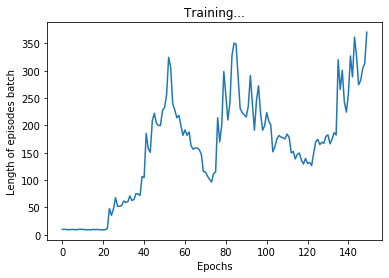

In [11]:
# Final plot
plt.figure(2)
plt.title('Training...')
plt.xlabel('Epochs')
plt.ylabel('Length of episodes batch')
plt.plot(torch.Tensor(all_epoch_lengths).numpy())
print("Last episode length is {}, epoch is {} and rand_act_pr {}".format(epoch_episode_length, epoch, opt_parameters['rand_act_pr']))
       

# Run it longer 

In [ ]:

env._max_episode_steps = 5000

state = env.reset() # reset environment
for t in range(env._max_episode_steps): # rollout one episode until it finishes or stop after 200 steps
    state_pytorch = torch.from_numpy(state).float().unsqueeze(0) # state=s
    action = Q_net.eval().select_action(state_pytorch, 0.0) # select action=a from state=s
    state, reward, done, _ = env.step(action) # receive next state=s' and reward=r
    env.render() # visualize state
    if done:
        print(t)
        break
        